In [38]:
import os
import requests
from tqdm import tqdm
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [32]:
# Create directory
DOWNLOAD_DIR = "datasets/paraguay"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

# Zenodo API
record_id = 4532361
api_url = f"https://zenodo.org/api/records/{record_id}"

print(" Fetching metadata from Zenodo...")
response = requests.get(api_url)
record = response.json()
files = record["files"]

print(f" {len(files)} files found — starting download...\n")

for f in files:
    file_name = f["key"]
    file_url = f["links"]["self"]
    dest_path = os.path.join(DOWNLOAD_DIR, file_name)

    # Skip if already downloaded
    if os.path.exists(dest_path):
        print(f" Skipped (already exists): {file_name}")
        continue

    print(f" Downloading: {file_name}")
    with requests.get(file_url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        with open(dest_path, "wb") as f_out, tqdm(
            total=total, unit="B", unit_scale=True
        ) as bar:
            for chunk in r.iter_content(chunk_size=8192):
                f_out.write(chunk)
                bar.update(len(chunk))

print("\n Download complete!")


 Fetching metadata from Zenodo...
 1 files found — starting download...

 Downloading: Database from fundus images for the study of diabetic retinopathy.zip


100%|███████████████████████████████████████████████████████████████████████████████| 238M/238M [00:14<00:00, 16.7MB/s]


 Download complete!


##  Displaying a Sample Fundus Image

To validate the dataset, we list all available fundus images and display one randomly chosen image using **PIL** and **Matplotlib**.

This helps confirm:
- Image format validity  
- Dataset folder structure  
- Visual inspection for dataset quality


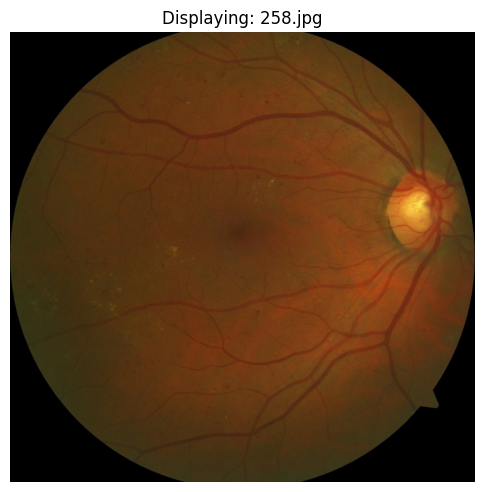

In [34]:
# Path to the dataset
DOWNLOAD_DIR = "datasets/paraguay/PDR"

# List all files in the directory
all_files = os.listdir(DOWNLOAD_DIR)

# Filter image files (common extensions)
image_files = [f for f in all_files if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".bmp"))]

if not image_files:
    print(" No image files found in the dataset.")
else:
    # Take the first image for display
    img_path = os.path.join(DOWNLOAD_DIR, image_files[0])
    img = Image.open(img_path)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Displaying: {image_files[0]}")
    plt.show()


##  Data Augmentation on HRF Dataset

The **High-Resolution Fundus (HRF)** dataset contains limited samples per class, so data augmentation is performed to enhance model generalization.

Augmentations applied include:
- Random rotation  
- Horizontal flip  
- Vertical mirror  
- Autocontrast  
- Equalization  
- Solarization  

 For each original image, **30 augmented variants** are generated and saved to `HRF/Augmented/<class>/`.


In [36]:

HRF_PATH = "Datasets/HRF"
ORIGINAL_PATH = os.path.join(HRF_PATH, "Original")
AUGMENTED_PATH = os.path.join(HRF_PATH, "Augmented")

# Create augmented subfolders
os.makedirs(os.path.join(AUGMENTED_PATH, "Healthy"), exist_ok=True)
os.makedirs(os.path.join(AUGMENTED_PATH, "diabetic_retinopathy"), exist_ok=True)

# Augmentation functions
def augment(img):
    augmentations = [
        lambda x: x.rotate(random.randint(-20, 20)),
        lambda x: ImageOps.flip(x),
        lambda x: ImageOps.mirror(x),
        lambda x: ImageOps.autocontrast(x),
        lambda x: ImageOps.equalize(x),
        lambda x: ImageOps.solarize(x, threshold=128),
    ]
    return random.choice(augmentations)(img)

# Loop through classes
for cls in ["Healthy", "diabetic_retinopathy"]:
    input_folder = os.path.join(ORIGINAL_PATH, cls)
    output_folder = os.path.join(AUGMENTED_PATH, cls)

    images = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"\n Augmenting class: {cls} ({len(images)} images found)")

    for img_name in tqdm(images):
        img_path = os.path.join(input_folder, img_name)
        img = Image.open(img_path)

        # generate 30 augmentations per image (change number if needed)
        for i in range(30):
            aug_img = augment(img)
            base, ext = os.path.splitext(img_name)
            aug_name = f"{base}_aug_{i+1}{ext}"
            aug_img.save(os.path.join(output_folder, aug_name))

print("\n Augmentation complete! All augmented images stored in HRF/Augmented folder.")



 Augmenting class: Healthy (15 images found)


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:35<00:00,  2.35s/it]



 Augmenting class: diabetic_retinopathy (15 images found)


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:32<00:00,  2.18s/it]


 Augmentation complete! All augmented images stored in HRF/Augmented folder.


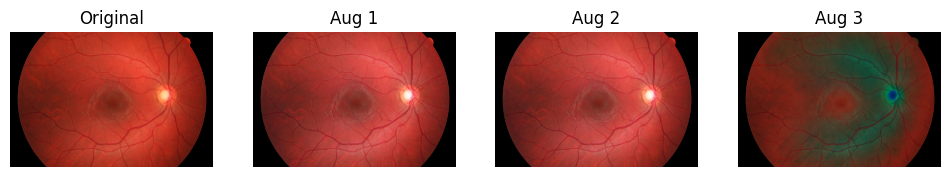

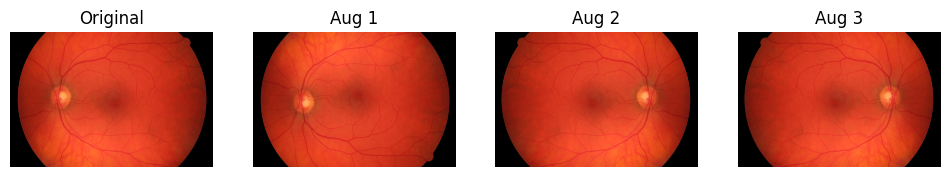

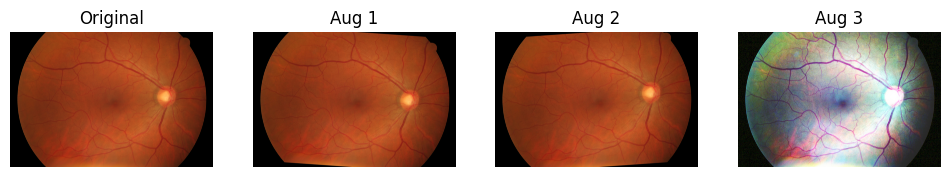

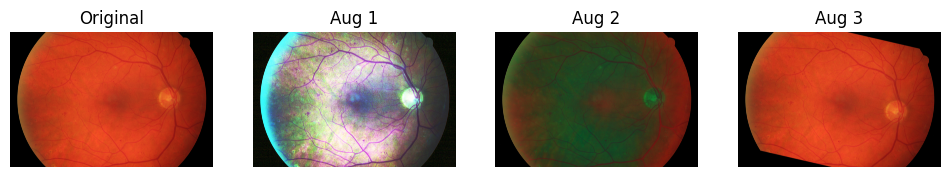

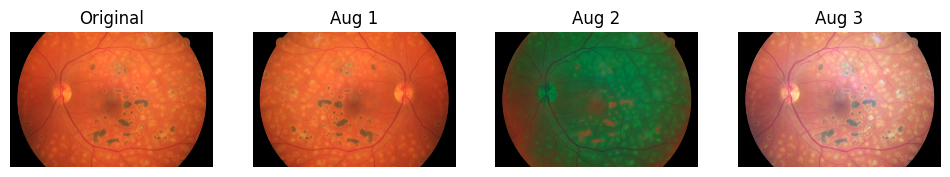

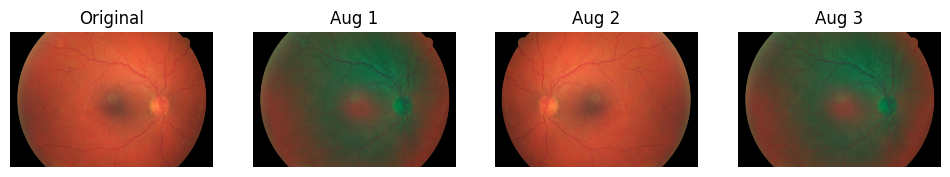

In [30]:
# Function to display original and augmented images side by side
def show_augmented_examples(cls, num_examples=3):
    input_folder = os.path.join(ORIGINAL_PATH, cls)
    output_folder = os.path.join(AUGMENTED_PATH, cls)

    original_images = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    augmented_images = [f for f in os.listdir(output_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not original_images or not augmented_images:
        print(f"No images found for class {cls}")
        return

    # Pick a few random original images
    examples = random.sample(original_images, min(num_examples, len(original_images)))

    for orig_name in examples:
        # Original image
        orig_path = os.path.join(input_folder, orig_name)
        orig_img = Image.open(orig_path)

        # Find corresponding augmented images
        base, ext = os.path.splitext(orig_name)
        related_aug = [f for f in augmented_images if f.startswith(base + "_aug")]

        # Pick up to 3 augmentations to display
        selected_aug = random.sample(related_aug, min(3, len(related_aug)))

        # Plot
        plt.figure(figsize=(12, 4))
        plt.subplot(1, len(selected_aug) + 1, 1)
        plt.imshow(orig_img)
        plt.title("Original")
        plt.axis("off")

        for i, aug_name in enumerate(selected_aug):
            aug_img = Image.open(os.path.join(output_folder, aug_name))
            plt.subplot(1, len(selected_aug) + 1, i + 2)
            plt.imshow(aug_img)
            plt.title(f"Aug {i+1}")
            plt.axis("off")

        plt.show()

# Display examples for both classes
for cls in ["Healthy", "diabetic_retinopathy"]:
    show_augmented_examples(cls)


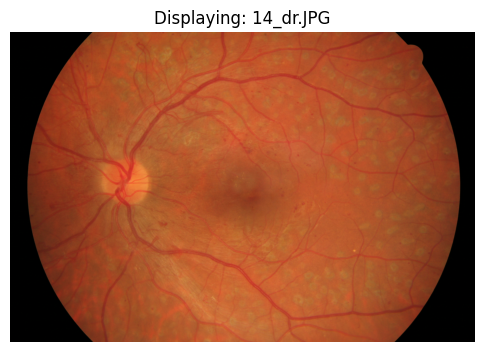

In [37]:
# Path to diabetic_retinopathy images
IMAGE_DIR = "datasets/HRF/Original/diabetic_retinopathy"

# List all image files
image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not image_files:
    print(" No images found in the folder.")
else:
    # Pick a random image to display
    img_name = random.choice(image_files)
    img_path = os.path.join(IMAGE_DIR, img_name)

    # Open and show image
    img = Image.open(img_path)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Displaying: {img_name}")
    plt.show()


In [26]:
HRF_PATH = "datasets/HRF"
UNIFIED_PATH = "datasets/Unified_Split"

ORIGINAL_PATH = os.path.join(HRF_PATH, "Original")
AUGMENTED_PATH = os.path.join(HRF_PATH, "Augmented")

CLASSES = ["Healthy", "diabetic_retinopathy"]

# Mapping to DR / No_DR
CLASS_MAPPING = {
    "Healthy": "No_DR",
    "diabetic_retinopathy": "DR"
}

# Folder structure creation
for split in ["train", "val", "test"]:
    for cls_mapped in CLASS_MAPPING.values():
        os.makedirs(os.path.join(UNIFIED_PATH, split, cls_mapped), exist_ok=True)

for cls in CLASSES:
    original_folder = os.path.join(ORIGINAL_PATH, cls)
    augmented_folder = os.path.join(AUGMENTED_PATH, cls)
    mapped_cls = CLASS_MAPPING[cls]

    # Collect original images
    original_images = [f for f in os.listdir(original_folder) if f.lower().endswith((".jpg", ".png", ".jpeg", ".tif"))]

    # Train/Val/Test split on ORIGINAL images only
    train_orig, temp = train_test_split(original_images, test_size=0.30, random_state=42)
    val_orig, test_orig = train_test_split(temp, test_size=0.50, random_state=42)

    # Copy originals to splits
    for img in train_orig:
        shutil.copy(os.path.join(original_folder, img), os.path.join(UNIFIED_PATH, "train", mapped_cls, img))
    for img in val_orig:
        shutil.copy(os.path.join(original_folder, img), os.path.join(UNIFIED_PATH, "val", mapped_cls, img))
    for img in test_orig:
        shutil.copy(os.path.join(original_folder, img), os.path.join(UNIFIED_PATH, "test", mapped_cls, img))

    print(f" Original images distributed for class '{cls}' → '{mapped_cls}' .")

    # Copy ALL augmented images ONLY to train split
    if os.path.exists(augmented_folder):
        for img in os.listdir(augmented_folder):
            if img.lower().endswith((".jpg", ".png", ".jpeg", ".tif")):
                shutil.copy(os.path.join(augmented_folder, img), os.path.join(UNIFIED_PATH, "train", mapped_cls, img))
        print(f" Augmented images copied to TRAIN for class '{cls}' → '{mapped_cls}' .")

print("\n Dataset splitting finished successfully!")
print("Train contains original + augmented | Val + Test contain only original.")


 Original images distributed for class 'Healthy' → 'No_DR' .
 Augmented images copied to TRAIN for class 'Healthy' → 'No_DR' .
 Original images distributed for class 'diabetic_retinopathy' → 'DR' .
 Augmented images copied to TRAIN for class 'diabetic_retinopathy' → 'DR' .

 Dataset splitting finished successfully!
Train contains original + augmented | Val + Test contain only original.


In [25]:
# Paths
BANGLADESH_ORIG = "datasets/Bangladesh/Original Dataset"
BANGLADESH_AUG = "datasets/Bangladesh/Augmented Dataset"
UNIFIED_DIR = "datasets/Unified_Split"  # <-- same unified folder as HRF

TRAIN_DIR = os.path.join(UNIFIED_DIR, "train")
VAL_DIR = os.path.join(UNIFIED_DIR, "val")
TEST_DIR = os.path.join(UNIFIED_DIR, "test")

# Classes
DR_CLASSES = ["Diabetic Retinopathy"]
NO_DR_CLASSES = ["Healthy", "Myopia", "Central Serous Chorioretinopathy [Color Fundus]"]


# Create directories
for split in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(os.path.join(split, "DR"), exist_ok=True)
    os.makedirs(os.path.join(split, "No_DR"), exist_ok=True)


# Function to copy images
def copy_images(file_list, src_folder, dst_folder, disease_name, split_name):
    print(f"\n Copying {len(file_list)} images from '{disease_name}' to {split_name}/{os.path.basename(dst_folder)}")
    for img_file in tqdm(file_list, desc=f"{disease_name} ({split_name})"):
        src_path = os.path.join(src_folder, img_file)
        dst_path = os.path.join(dst_folder, img_file)
        shutil.copy2(src_path, dst_path)


# Process each class
for dataset_type, source_dir in [("Original", BANGLADESH_ORIG), ("Augmented", BANGLADESH_AUG)]:
    for disease_folder in os.listdir(source_dir):
        disease_path = os.path.join(source_dir, disease_folder)
        if not os.path.isdir(disease_path):
            continue

        # Determine class
        if disease_folder in DR_CLASSES:
            class_name = "DR"
        elif disease_folder in NO_DR_CLASSES:
            class_name = "No_DR"
        else:
            print(f" Skipped {dataset_type} disease: {disease_folder}")
            continue

        # List all images
        all_images = os.listdir(disease_path)

        if dataset_type == "Original":
            # Split original images into train, val, test
            train_files, temp_files = train_test_split(all_images, test_size=0.4, random_state=42)
            val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

            # Copy to respective folders
            copy_images(train_files, disease_path, os.path.join(TRAIN_DIR, class_name), disease_folder, "train")
            copy_images(val_files, disease_path, os.path.join(VAL_DIR, class_name), disease_folder, "val")
            copy_images(test_files, disease_path, os.path.join(TEST_DIR, class_name), disease_folder, "test")

        else:  # Augmented images go only to train
            copy_images(all_images, disease_path, os.path.join(TRAIN_DIR, class_name), disease_folder, "train (augmented)")

print("\n Bangladesh dataset successfully split into train (original+augmented), val, and test (original only) in the unified folder")



 Copying 52 images from 'Central Serous Chorioretinopathy [Color Fundus]' to train/No_DR


Central Serous Chorioretinopathy [Color Fundus] (train): 100%|████████████████████████| 52/52 [00:00<00:00, 351.21it/s]



 Copying 17 images from 'Central Serous Chorioretinopathy [Color Fundus]' to val/No_DR


Central Serous Chorioretinopathy [Color Fundus] (val): 100%|██████████████████████████| 17/17 [00:00<00:00, 399.47it/s]



 Copying 18 images from 'Central Serous Chorioretinopathy [Color Fundus]' to test/No_DR


Central Serous Chorioretinopathy [Color Fundus] (test): 100%|█████████████████████████| 18/18 [00:00<00:00, 421.86it/s]



 Copying 905 images from 'Diabetic Retinopathy' to train/DR


Diabetic Retinopathy (train): 100%|█████████████████████████████████████████████████| 905/905 [00:03<00:00, 271.94it/s]



 Copying 302 images from 'Diabetic Retinopathy' to val/DR


Diabetic Retinopathy (val): 100%|███████████████████████████████████████████████████| 302/302 [00:00<00:00, 421.55it/s]



 Copying 302 images from 'Diabetic Retinopathy' to test/DR


Diabetic Retinopathy (test): 100%|██████████████████████████████████████████████████| 302/302 [00:00<00:00, 436.49it/s]


 Skipped Original disease: Disc Edema
 Skipped Original disease: Glaucoma

 Copying 614 images from 'Healthy' to train/No_DR


Healthy (train): 100%|██████████████████████████████████████████████████████████████| 614/614 [00:01<00:00, 373.46it/s]



 Copying 205 images from 'Healthy' to val/No_DR


Healthy (val): 100%|████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 394.51it/s]



 Copying 205 images from 'Healthy' to test/No_DR


Healthy (test): 100%|███████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 413.05it/s]


 Skipped Original disease: Macular Scar

 Copying 300 images from 'Myopia' to train/No_DR


Myopia (train): 100%|███████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 371.04it/s]



 Copying 100 images from 'Myopia' to val/No_DR


Myopia (val): 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 397.38it/s]



 Copying 100 images from 'Myopia' to test/No_DR


Myopia (test): 100%|████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 226.45it/s]


 Skipped Original disease: Pterygium
 Skipped Original disease: Retinal Detachment
 Skipped Original disease: Retinitis Pigmentosa

 Copying 596 images from 'Central Serous Chorioretinopathy [Color Fundus]' to train (augmented)/No_DR


Central Serous Chorioretinopathy [Color Fundus] (train (augmented)): 100%|██████████| 596/596 [00:03<00:00, 150.24it/s]



 Copying 3444 images from 'Diabetic Retinopathy' to train (augmented)/DR


Diabetic Retinopathy (train (augmented)): 100%|███████████████████████████████████| 3444/3444 [00:06<00:00, 524.11it/s]


 Skipped Augmented disease: Disc Edema
 Skipped Augmented disease: Glaucoma

 Copying 2676 images from 'Healthy' to train (augmented)/No_DR


Healthy (train (augmented)): 100%|████████████████████████████████████████████████| 2676/2676 [00:05<00:00, 475.47it/s]


 Skipped Augmented disease: Macular Scar

 Copying 2251 images from 'Myopia' to train (augmented)/No_DR


Myopia (train (augmented)): 100%|█████████████████████████████████████████████████| 2251/2251 [00:04<00:00, 520.22it/s]

 Skipped Augmented disease: Pterygium
 Skipped Augmented disease: Retinal Detachment
 Skipped Augmented disease: Retinitis Pigmentosa

 Bangladesh dataset successfully split into train (original+augmented), val, and test (original only) in the unified folder


In [27]:
# Paths
PARAGUAY_DIR = "datasets/paraguay"
UNIFIED_DIR = "datasets/Unified_Split"  

TRAIN_DIR = os.path.join(UNIFIED_DIR, "train")
VAL_DIR = os.path.join(UNIFIED_DIR, "val")
TEST_DIR = os.path.join(UNIFIED_DIR, "test")


# Classes mapping
DR_CLASSES = [
    "Mild (or early) NPDR",
    "Moderate NPDR",
    "Severe NPDR",
    "Very Severe NPDR",
    "PDR",
    "Advanced PDR"
]
NO_DR_CLASSES = ["No DR signs"]


# Create folders
for split in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(os.path.join(split, "DR"), exist_ok=True)
    os.makedirs(os.path.join(split, "No_DR"), exist_ok=True)


# Function to copy images with tqdm and print
def copy_images(file_list, src_folder, dst_folder, disease_name, split_name):
    print(f"\n Copying {len(file_list)} images from '{disease_name}' to {split_name}/{os.path.basename(dst_folder)}")
    for img_file in tqdm(file_list, desc=f"{disease_name} ({split_name})"):
        src_path = os.path.join(src_folder, img_file)
        dst_path = os.path.join(dst_folder, img_file)
        shutil.copy2(src_path, dst_path)


# Process Paraguay dataset
for disease_folder in os.listdir(PARAGUAY_DIR):
    disease_path = os.path.join(PARAGUAY_DIR, disease_folder)
    if not os.path.isdir(disease_path):
        continue

    # Determine class mapping
    if disease_folder in DR_CLASSES:
        mapped_cls = "DR"
    elif disease_folder in NO_DR_CLASSES:
        mapped_cls = "No_DR"
    else:
        print(f" Skipped folder: {disease_folder}")
        continue

    # List all images
    all_images = [f for f in os.listdir(disease_path) if f.lower().endswith((".jpg", ".png", ".jpeg", ".tif"))]

    # Split into train / val / test (e.g., 60/20/20)
    train_files, temp_files = train_test_split(all_images, test_size=0.4, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    # Copy images to respective folders
    copy_images(train_files, disease_path, os.path.join(TRAIN_DIR, mapped_cls), disease_folder, "train")
    copy_images(val_files, disease_path, os.path.join(VAL_DIR, mapped_cls), disease_folder, "val")
    copy_images(test_files, disease_path, os.path.join(TEST_DIR, mapped_cls), disease_folder, "test")

print("\n Paraguay dataset successfully split into train, val, and test in Unified_Split/DR and No_DR")



 Copying 41 images from 'Advanced PDR' to train/DR


Advanced PDR (train): 100%|████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.52it/s]



 Copying 14 images from 'Advanced PDR' to val/DR


Advanced PDR (val): 100%|██████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 72.65it/s]



 Copying 14 images from 'Advanced PDR' to test/DR


Advanced PDR (test): 100%|█████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 66.08it/s]



 Copying 2 images from 'Mild (or early) NPDR' to train/DR


Mild (or early) NPDR (train): 100%|██████████████████████████████████████████████████████| 2/2 [00:00<00:00, 62.50it/s]



 Copying 1 images from 'Mild (or early) NPDR' to val/DR


Mild (or early) NPDR (val): 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.78it/s]



 Copying 1 images from 'Mild (or early) NPDR' to test/DR


Mild (or early) NPDR (test): 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.70it/s]



 Copying 34 images from 'Moderate NPDR' to train/DR


Moderate NPDR (train): 100%|███████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 65.94it/s]



 Copying 12 images from 'Moderate NPDR' to val/DR


Moderate NPDR (val): 100%|█████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 70.42it/s]



 Copying 12 images from 'Moderate NPDR' to test/DR


Moderate NPDR (test): 100%|████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 67.67it/s]



 Copying 12 images from 'No DR signs' to train/No_DR


No DR signs (train): 100%|█████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 72.32it/s]



 Copying 4 images from 'No DR signs' to val/No_DR


No DR signs (val): 100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 73.25it/s]



 Copying 4 images from 'No DR signs' to test/No_DR


No DR signs (test): 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 77.94it/s]



 Copying 42 images from 'PDR' to train/DR


PDR (train): 100%|█████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 63.25it/s]



 Copying 14 images from 'PDR' to val/DR


PDR (val): 100%|███████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 62.38it/s]



 Copying 14 images from 'PDR' to test/DR


PDR (test): 100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 69.47it/s]



 Copying 55 images from 'Severe NPDR' to train/DR


Severe NPDR (train): 100%|█████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 65.83it/s]



 Copying 18 images from 'Severe NPDR' to val/DR


Severe NPDR (val): 100%|███████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 62.27it/s]



 Copying 19 images from 'Severe NPDR' to test/DR


Severe NPDR (test): 100%|██████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 58.04it/s]



 Copying 49 images from 'Very Severe NPDR' to train/DR


Very Severe NPDR (train): 100%|████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 69.94it/s]



 Copying 17 images from 'Very Severe NPDR' to val/DR


Very Severe NPDR (val): 100%|██████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 67.33it/s]



 Copying 17 images from 'Very Severe NPDR' to test/DR


Very Severe NPDR (test): 100%|█████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 64.87it/s]


 Paraguay dataset successfully split into train, val, and test in Unified_Split/DR and No_DR


##  Final Unified Dataset — Image Distribution

The following cell prints the distribution of images per class:

``train / val / test`` × ``DR / No_DR``

Purpose:
- Verify split balance
- Check augmentation count
- Validate successful merging of all datasets

This final unified dataset is ready for:
- Model training
- Evaluation
- Deployment


In [28]:
UNIFIED_DIR = "datasets/Unified_Split"
splits = ["train", "val", "test"]
classes = ["DR", "No_DR"]

for split in splits:
    print(f"\n== {split.upper()} ==")
    for cls in classes:
        folder = os.path.join(UNIFIED_DIR, split, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".png", ".jpeg", ".tif"))])
        print(f"{cls}: {count} images")



== TRAIN ==
DR: 4127 images
No_DR: 5995 images

== VAL ==
DR: 380 images
No_DR: 328 images

== TEST ==
DR: 382 images
No_DR: 330 images
